In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu từ file CSV
data = pd.read_csv(r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe\MaMe-FeMos-FeMe-d4-5ng_tracking_data.csv")

# Sắp xếp dữ liệu theo Object ID và Frame
data = data.sort_values(by=['Object ID', 'Frame'])

# Định nghĩa các ranh giới X cho các phần (part)
x1 = 740  # X1: giới hạn giữa phần 0 và phần 1
x2 = 1165  # X2: giới hạn giữa phần 1 và phần 2

# Tính toán khoảng cách (Euclidean distance) giữa các frame liên tiếp cho cùng một Object ID
data['X_diff'] = data.groupby('Object ID')['X Center'].diff().fillna(0)
data['Y_diff'] = data.groupby('Object ID')['Y Center'].diff().fillna(0)

# Tính khoảng cách Euclidean (tốc độ) giữa các frame
data['Distance'] = np.sqrt(data['X_diff']**2 + data['Y_diff']**2)

# Tính tổng khoảng cách cho mỗi Object ID
total_distance_per_object_id = data.groupby('Object ID')['Distance'].sum().reset_index()
total_distance_per_object_id.rename(columns={'Distance': 'total_distance'}, inplace=True)

# Kết hợp tổng khoảng cách vào bảng dữ liệu gốc
data = data.merge(total_distance_per_object_id[['Object ID', 'total_distance']], on='Object ID', how='left')

# Tính tốc độ trung bình cho mỗi Object ID
data['average_velocity_by_object_id'] = data.groupby('Object ID')['Distance'].transform('mean')

# Tính phần (part) dựa trên giá trị X Center
data['part'] = pd.cut(data['X Center'], bins=[-np.inf, x1, x2, np.inf], labels=[0, 1, 2])

# Tính tốc độ trung bình cho mỗi phần
data['average_velocity_by_part'] = data.groupby('part')['Distance'].transform('mean')

# Loại bỏ các cột phụ (X_diff, Y_diff)
data = data.drop(columns=['X_diff', 'Y_diff'])

# Hiển thị các cột cuối cùng
final_data = data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Distance', 'average_velocity_by_object_id', 'average_velocity_by_part', 'part', 'total_distance']]

# In kết quả đầu ra
print(final_data.head())

# Lưu kết quả vào file CSV mới (nếu cần)
final_data.to_csv(r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe\MaMe-FeMos-FeMe-d4-5ng_tracking_data_processed.csv", index=False)

# Vẽ đồ thị tốc độ theo Frame cho từng Object ID
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_data, x='Frame', y='Distance', hue='Object ID', marker='o')

# Cài đặt tên cho đồ thị
plt.title('Velocity per Frame for Each Object ID')
plt.xlabel('Frame')
plt.ylabel('Velocity (m/s)')
plt.legend(title='Object ID')
plt.grid(True)

# Hiển thị đồ thị
plt.show()

# Vẽ đồ thị tốc độ trung bình theo Object ID
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_data, x='Object ID', y='average_velocity_by_object_id', marker='o')

# Cài đặt tên cho đồ thị
plt.title('Average Velocity per Object ID')
plt.xlabel('Object ID')
plt.ylabel('Average Velocity (m/s)')
plt.grid(True)

# Hiển thị đồ thị
plt.show()


C:\Users\MAY02\AppData\Local\Temp\ipykernel_11720\849396986.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['average_velocity_by_part'] = data.groupby('part')['Distance'].transform('mean')


KeyError: "['total_distance'] not in index"

In [ ]:
import csv
import os
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import cv2
import numpy as np

class ObjectTracker:
    def __init__(self, model_path, video_folder, pixel_to_meter):
        # Load YOLOv8 model
        self.model = YOLO(model_path)

        # Initialize DeepSORT tracker
        self.tracker = DeepSort(max_age=3, max_cosine_distance=0.01)

        # Store previous positions and tracking data
        self.previous_positions = {}
        self.tracking_data = []
        self.pixel_to_meter = pixel_to_meter  # Conversion factor from pixels to meters

        # Get all video files in the folder
        self.video_files = [f for f in os.listdir(video_folder) if f.endswith('.MOV')]
        self.video_folder = video_folder

        if not self.video_files:
            raise ValueError("No .MOV files found in the specified video folder.")

    def calculate_velocity(self, track_id, current_position, fps):
        if track_id in self.previous_positions:
            previous_position = self.previous_positions[track_id]
            displacement = np.linalg.norm(current_position - previous_position)
            velocity = displacement * fps * self.pixel_to_meter
        else:
            velocity = 0
        self.previous_positions[track_id] = current_position
        return velocity

    def draw_bounding_box(self, frame, bbox, track_id, velocity):
        cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
        cv2.putText(frame, f'ID: {track_id}', (int(bbox[0]), int(bbox[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        cv2.putText(frame, f'Vel: {velocity:.2f} m/s', (int(bbox[0]), int(bbox[1])-40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    def process_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise Exception(f"Could not open video file: {video_path}")

        fps = cap.get(cv2.CAP_PROP_FPS)

        self.previous_positions.clear()
        self.tracking_data.clear()

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            results = self.model(frame)
            detections = results[0].boxes.data

            dets = []
            for box in detections:
                x1, y1, x2, y2, conf, cls = box.cpu().numpy()
                width = x2 - x1
                height = y2 - y1
                dets.append([[x1, y1, width, height], conf])

            tracks = self.tracker.update_tracks(dets, frame=frame)

            for track in tracks:
                if track.is_confirmed():
                    track_id = track.track_id
                    bbox = track.to_tlbr()
                    x_center = (bbox[0] + bbox[2]) / 2
                    y_center = (bbox[1] + bbox[3]) / 2
                    current_position = np.array([x_center, y_center])

                    velocity = self.calculate_velocity(track_id, current_position, fps)
                    self.draw_bounding_box(frame, bbox, track_id, velocity)

                    self.tracking_data.append([cap.get(cv2.CAP_PROP_POS_FRAMES), track_id, x_center, y_center, velocity])

        cap.release()

    def export_tracking_data(self, csv_path):
        with open(csv_path, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)'])
            csvwriter.writerows(self.tracking_data)

    def run(self):
        for video_file in self.video_files:
            video_path = os.path.join(self.video_folder, video_file)

            output_folder = os.path.join(self.video_folder, video_file.replace('.MOV', '_output'))
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            print(f"Processing video: {video_file}")
            self.process_video(video_path)
            self.export_tracking_data(os.path.join(output_folder, f'{video_file.replace(".MOV", "_tracking_data.csv")}'))

# Usage
pixel_to_meter = 0.01  # Example conversion factor
video_folder = r'C:\Users\MAY02\Desktop\FishTracking-\Test'  # Ensure this path is correct

tracker = ObjectTracker('bestYOLOV8x.pt', video_folder, pixel_to_meter)

try:
    tracker.run()
except Exception as e:
    print(f"An error occurred: {e}")


Processing video: MaMe-FeMos-FeMe-d4-5ng.MOV

0: 384x640 9 fishs, 39.7ms
Speed: 3.0ms preprocess, 39.7ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 31.8ms
Speed: 2.0ms preprocess, 31.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 36.4ms
Speed: 2.0ms preprocess, 36.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 33.0ms
Speed: 1.0ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 38.2ms
Speed: 1.0ms preprocess, 38.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 36.6ms
Speed: 2.0ms preprocess, 36.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 36.6ms
Speed: 1.0ms preprocess, 36.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 fishs, 36.9ms
Speed: 1.0ms preprocess, 36.9ms inference, 0.0ms pos

In [49]:
import os
import pandas as pd

# Input folder containing CSV files
input_folder = r"C:\Users\MAY02\Desktop\FishTracking-\Data\FeMe-MaMos-MaMe"

# Initialize dictionaries to store average velocities
average_velocities = {0: [], 1: [], 2: []}  # 0 -> FeMe, 1 -> MaMos, 2 -> MaMe
time_points = []

# Process each file in the folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        print(file_name)
        # Full path to the file
        file_path = os.path.join(input_folder, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        print(df)
        
        # # Group by 'part' and calculate mean 'average_velocity_by_part'
        grouped = df.groupby('part')['average_velocity_by_part'].mean()
        
        # # Append the results to the corresponding lists
        for part in average_velocities.keys():
            average_velocities[part].append(grouped.get(part, 0))  # Default to 0 if part is missing

# Convert parts to labels for readability
labels = {0: 'MaMe', 1: 'FeMos', 2: 'FeMe'}
average_velocities_named = {labels[key]: values for key, values in average_velocities.items()}

# Display the collected average velocities for each part
print("Collected Average Velocities by Part:")
for part, velocities in average_velocities_named.items():
    print(f"{part}: {velocities}")



print(f"\nSummary saved to: {output_file}")
`

FeMe-MaMos-MaMe-d0-0ng_tracking_data.csv
          Frame  Object ID     X Center    Y Center  Velocity (m/s)  part  \
0           3.0          1   633.440132  287.977144        0.000000     0   
1           3.0          2   768.929636  305.046997        0.000000     1   
2           3.0          3  1476.441488  593.084968        0.000000     2   
3           3.0          4  1501.718399  662.272302        0.000000     2   
4           3.0          5   836.842958  220.352738        0.000000     1   
...         ...        ...          ...         ...             ...   ...   
193588  18045.0       4933   795.103702  292.614309        0.020780     1   
193589  18045.0       4937   681.685089  696.430108        0.033542     0   
193590  18045.0       4940  1002.644033  633.276766        0.024104     1   
193591  18045.0       4941  1486.716574  556.487623        0.140265     2   
193592  18045.0       4943   679.829334  615.966666        0.072909     0   

        average_velocity_by_object

In [61]:
import os
import pandas as pd

# Input folder containing CSV files
input_folder = r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe"

# Initialize dictionaries to store average velocities
average_velocities = {0: [], 1: [], 2: []}  # 0 -> FeMe, 1 -> MaMos, 2 -> MaMe
time_points = []

# Process each file in the folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        print(file_name)
        # Full path to the file
        file_path = os.path.join(input_folder, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        print(df)
        
        # # Group by 'part' and calculate mean 'average_velocity_by_part'
        grouped = df.groupby('part')['average_velocity_by_part'].mean()
        
        # # Append the results to the corresponding lists
        for part in average_velocities.keys():
            average_velocities[part].append(grouped.get(part, 0))  # Default to 0 if part is missing

# Convert parts to labels for readability
labels = {0: 'MaMe', 1: 'FeMos', 2: 'FeMe'}
average_velocities_named = {labels[key]: values for key, values in average_velocities.items()}

# Display the collected average velocities for each part
print("Collected Average Velocities by Part:")
for part, velocities in average_velocities_named.items():
    print(f"{part}: {velocities}")



print(f"\nSummary saved to: {output_file}")


MaMe-FeMos-FeMe-d0-0ng_tracking_data.csv
          Frame  Object ID     X Center    Y Center  Velocity (m/s)  part  \
0           1.0      45094   523.598187  621.117271        0.000000     0   
1           1.0      45266   450.494982  456.825442        0.000000     0   
2           1.0      45274   598.206179  315.211574        0.000000     0   
3           1.0      45289   873.870017  845.868835        0.000000     1   
4           1.0      45298  1187.263934  251.630842        0.000000     2   
...         ...        ...          ...         ...             ...   ...   
208712  18045.0      52813  1062.471559  604.535355        0.041022     1   
208713  18045.0      52834   802.324450  766.102552        0.289181     1   
208714  18045.0      52836   845.761902  689.480136        1.836055     1   
208715  18045.0      52838  1188.092597  814.566199        0.472781     2   
208716  18045.0      52841   575.695170  882.561204        0.056113     0   

        average_velocity_by_object

In [ ]:
import os
import pandas as pd

# Input folder containing CSV files
input_folder = r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe"

# Initialize dictionaries to store average velocities
average_velocities = {0: [], 1: [], 2: []}  # 0 -> FeMe, 1 -> MaMos, 2 -> MaMe
time_points = []

# Process each file in the folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        print(file_name)
        # Full path to the file
        file_path = os.path.join(input_folder, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        print(df)
        
        # # Group by 'part' and calculate mean 'average_velocity_by_part'
        grouped = df.groupby('part')['average_velocity_by_part'].mean()
        
        # # Append the results to the corresponding lists
        for part in average_velocities.keys():
            average_velocities[part].append(grouped.get(part, 0))  # Default to 0 if part is missing

# Convert parts to labels for readability
labels = {0: 'MaMe', 1: 'FeMos', 2: 'FeMe'}
average_velocities_named = {labels[key]: values for key, values in average_velocities.items()}

# Display the collected average velocities for each part
print("Collected Average Velocities by Part:")
for part, velocities in average_velocities_named.items():
    print(f"{part}: {velocities}")



print(f"\nSummary saved to: {output_file}")


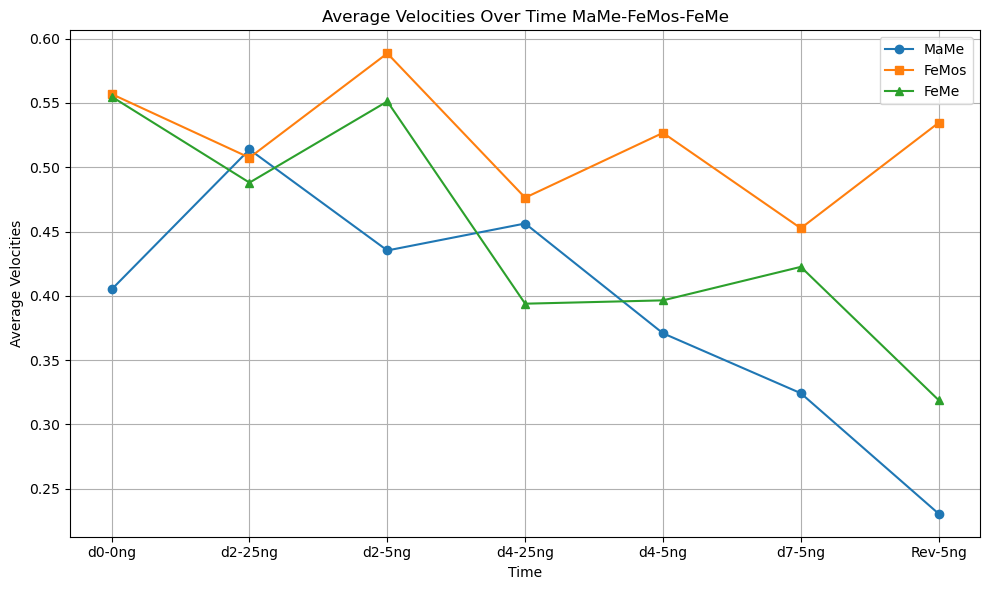

In [86]:
MaMe =[0.404971149029692, 0.5137906179104504, 0.43526493737217903, 0.456228171504162, 0.3708484984762865, 0.3242325792640491, 0.2305341766610674]
FeMos =[0.5569075017648862, 0.5074266057020352, 0.5885575030757783, 0.4763049712130347, 0.5267192717780576, 0.4525407844213348, 0.5345667983253576]
FeMe= [0.5548855308804376, 0.4880200571544823, 0.5511778755062122, 0.3938628634790321, 0.3964481584484216, 0.42250598005677337, 0.3188765216488169]

Time = ['d0-0ng', 'd2-25ng', 'd2-5ng','d4-25ng', 'd4-5ng', 'd7-5ng', 'Rev-5ng']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Time, MaMe, label='MaMe', marker='o')
plt.plot(Time, FeMos, label='FeMos', marker='s')
plt.plot(Time, FeMe, label='FeMe', marker='^')

# Labels and Title
plt.xlabel('Time')
plt.ylabel('Average Velocities')
plt.title('Average Velocities Over Time MaMe-FeMos-FeMe')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig("Average Velocities Over Time MaMe-FeMos-FeMe.jpg")
plt.show()



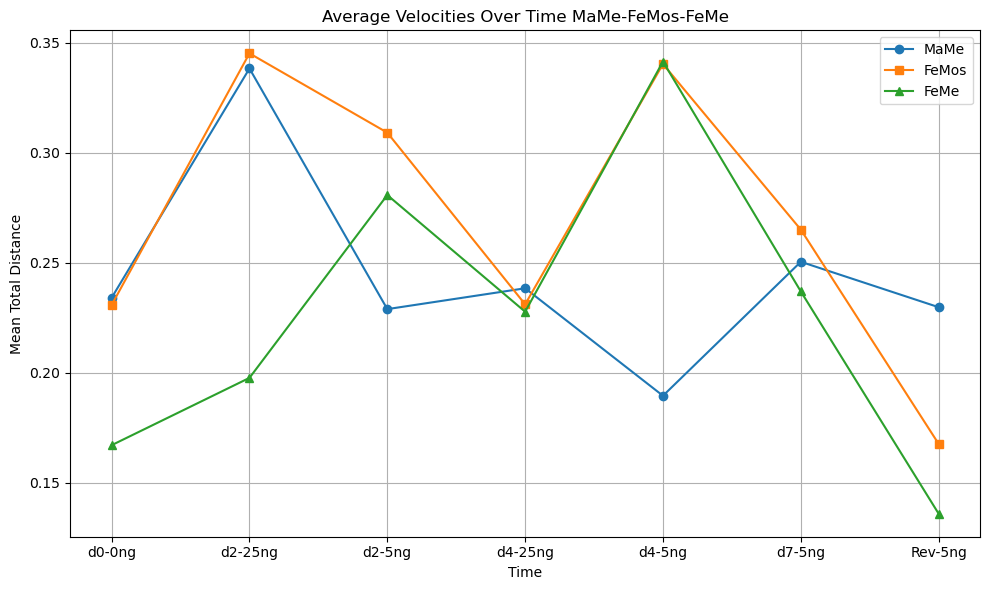

In [85]:

MaMe = [0.23409361300485657, 0.3382565834122952, 0.228949056256825, 0.238416324514276, 0.1895881992367852, 0.25044405345462367, 0.2298236008179891]
FeMos=  [0.23081695454875115, 0.3451362200743786, 0.3091076812902469, 0.23112458016325288, 0.3402914068893325, 0.26507008115663383, 0.1677284611024286]
FeMe =  [0.16713859825970187, 0.19771689597356676, 0.28076657784969405, 0.227765277077607, 0.34140360443352985, 0.23698306134965264, 0.13601195373606376]

Time = ['d0-0ng', 'd2-25ng', 'd2-5ng','d4-25ng', 'd4-5ng', 'd7-5ng', 'Rev-5ng']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Time, MaMe, label='MaMe', marker='o')
plt.plot(Time, FeMos, label='FeMos', marker='s')
plt.plot(Time, FeMe, label='FeMe', marker='^')

# Labels and Title
plt.xlabel('Time')
plt.ylabel('Mean Total Distance')
plt.title('Average Velocities Over Time MaMe-FeMos-FeMe')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig("Mean Total Distance Over Time MaMe-FeMos-FeMe.jpg")
plt.show()



In [82]:
import pandas as pd
import numpy as np

# Load the data for additional analysis (Assume the CSV has Frame, Object ID, X Center, Y Center columns)
data = pd.read_csv(r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe\MaMe-FeMos-FeMe-d4-5ng_tracking_data.csv")

# Sort by object ID and frame number
data = data.sort_values(by=['Object ID', 'Frame'])

# Define x-coordinate ranges for the three parts
x1 = 740
x2 = 1165

# Calculate distances (Euclidean distance between consecutive frames for the same Object ID)
data['X_diff'] = data.groupby('Object ID')['X Center'].diff().fillna(0)
data['Y_diff'] = data.groupby('Object ID')['Y Center'].diff().fillna(0)

# Calculate the Euclidean distance (in pixels) between frames
data['Distance'] = np.sqrt(data['X_diff']**2 + data['Y_diff']**2)*0.001

# Calculate total distance for each Object ID
total_distance_per_object_id = data.groupby('Object ID')['Distance'].sum().reset_index()

# Rename the total distance column to avoid conflicts
total_distance_per_object_id.rename(columns={'Distance': 'total_distance'}, inplace=True)

# Merge the total distance back to the original dataframe
data = data.merge(total_distance_per_object_id[['Object ID', 'total_distance']], on='Object ID', how='left')

# Calculate average_velocity_by_object_id (velocity in pixels per frame)
data['average_velocity_by_object_id'] = data.groupby('Object ID')['Distance'].transform('mean')

# Calculate average_velocity_by_part for each part (velocity for each part)
data['part'] = pd.cut(data['X Center'], bins=[-np.inf, x1, x2, np.inf], labels=[0, 1, 2])
data['average_velocity_by_part'] = data.groupby('part')['Distance'].transform('mean')

# Drop the intermediate columns ('X_diff', 'Y_diff')
data = data.drop(columns=['X_diff', 'Y_diff'])

# Display the final DataFrame with the required columns
final_data = data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Distance', 'average_velocity_by_object_id', 'average_velocity_by_part', 'part', 'total_distance']]

# Show the final result
print(final_data.head())

# Optionally, save the results to a CSV file
final_data.to_csv(r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe\MaMe-FeMos-FeMe-d4-5ng_tracking_data.csv", index=False)


C:\Users\MAY02\AppData\Local\Temp\ipykernel_45456\3826064824.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['average_velocity_by_part'] = data.groupby('part')['Distance'].transform('mean')


   Frame  Object ID    X Center    Y Center  Distance  \
0    3.0          1  832.854063  638.061758  0.000000   
1    4.0          1  833.442699  637.556336  0.000776   
2    5.0          1  834.131576  637.233548  0.000761   
3    6.0          1  834.472789  636.934331  0.000454   
4    7.0          1  834.092140  636.899148  0.000382   

   average_velocity_by_object_id  average_velocity_by_part part  \
0                       0.002887                  0.001757    1   
1                       0.002887                  0.001757    1   
2                       0.002887                  0.001757    1   
3                       0.002887                  0.001757    1   
4                       0.002887                  0.001757    1   

   total_distance  
0        0.170332  
1        0.170332  
2        0.170332  
3        0.170332  
4        0.170332  


In [83]:
import pandas as pd
import numpy as np

# Load the data for additional analysis (Assume the CSV has Frame, Object ID, X Center, Y Center columns)
data = pd.read_csv(r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe\MaMe-FeMos-FeMe-Rev-5ng_tracking_data.csv")

# Sort by object ID and frame number
data = data.sort_values(by=['Object ID', 'Frame'])

# Define x-coordinate ranges for the three parts
x1 = 740
x2 = 1165

# Calculate distances (Euclidean distance between consecutive frames for the same Object ID)
data['X_diff'] = data.groupby('Object ID')['X Center'].diff().fillna(0)
data['Y_diff'] = data.groupby('Object ID')['Y Center'].diff().fillna(0)

# Calculate the Euclidean distance (in pixels) between frames
data['Distance'] = np.sqrt(data['X_diff']**2 + data['Y_diff']**2)*0.001

# Calculate total distance for each Object ID
total_distance_per_object_id = data.groupby('Object ID')['Distance'].sum().reset_index()

# Rename the total distance column to avoid conflicts
total_distance_per_object_id.rename(columns={'Distance': 'total_distance'}, inplace=True)

# Merge the total distance back to the original dataframe
data = data.merge(total_distance_per_object_id[['Object ID', 'total_distance']], on='Object ID', how='left')

# Calculate average_velocity_by_object_id (velocity in pixels per frame)
data['average_velocity_by_object_id'] = data.groupby('Object ID')['Distance'].transform('mean')

# Calculate average_velocity_by_part for each part (velocity for each part)
data['part'] = pd.cut(data['X Center'], bins=[-np.inf, x1, x2, np.inf], labels=[0, 1, 2])
data['average_velocity_by_part'] = data.groupby('part')['Distance'].transform('mean')

# Drop the intermediate columns ('X_diff', 'Y_diff')
data = data.drop(columns=['X_diff', 'Y_diff'])

# Display the final DataFrame with the required columns
final_data = data[['Frame', 'Object ID', 'X Center', 'Y Center', 'Distance', 'average_velocity_by_object_id', 'average_velocity_by_part', 'part', 'total_distance']]

# Show the final result
print(final_data.head())

# Optionally, save the results to a CSV file
final_data.to_csv(r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe\MaMe-FeMos-FeMe-Rev-5ng_tracking_data.csv", index=False)


C:\Users\MAY02\AppData\Local\Temp\ipykernel_45456\3203666760.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data['average_velocity_by_part'] = data.groupby('part')['Distance'].transform('mean')


   Frame  Object ID     X Center    Y Center  Distance  \
0    1.0      76886   995.092288  754.360384  0.000000   
1    2.0      76886   995.100429  754.369722  0.000012   
2    3.0      76886   995.108570  754.379061  0.000012   
3    1.0      76911  1365.200687  326.843594  0.000000   
4    2.0      76911  1365.198362  326.790902  0.000053   

   average_velocity_by_object_id  average_velocity_by_part part  \
0                       0.000008                  0.001784    1   
1                       0.000008                  0.001784    1   
2                       0.000008                  0.001784    1   
3                       0.000035                  0.001064    2   
4                       0.000035                  0.001064    2   

   total_distance  
0        0.000025  
1        0.000025  
2        0.000025  
3        0.000105  
4        0.000105  


In [13]:
df = pd.read_csv(r"C:\Users\MAY02\Desktop\FishTracking-\Data\FeMe-MaMos-MaMe\FeMe-MaMos-MaMe-d0-0ng_tracking_data.csv")  # Replace `file_path` with the actual path
print(df.columns)


Index(['Frame', 'Object ID', 'X Center', 'Y Center', 'Velocity (m/s)', 'part',
       'average_velocity_by_object_id', 'average_velocity_by_part', 'Distance',
       'total_distance'],
      dtype='object')


In [84]:
import os
import pandas as pd

# Input folder containing CSV files
input_folder = r"C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe"

# Initialize dictionaries to store average velocities and total distances
average_velocities = {0: [], 1: [], 2: []}  # 0 -> FeMe, 1 -> MaMos, 2 -> MaMe
total_distances = {0: [], 1: [], 2: []}  # 0 -> FeMe, 1 -> MaMos, 2 -> MaMe
time_points = []

# Process each file in the folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        # Full path to the file
        file_path = os.path.join(input_folder, file_name)
        
        # Extract the time label from the file name
        time_label = file_name.replace('_tracking_data.csv', '')
        time_points.append(time_label)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Group by 'part' and calculate mean 'average_velocity_by_part' and total distance
        grouped = df.groupby('part').agg(
            average_velocity=('average_velocity_by_part', 'mean'),
            total_distance=('total_distance', 'mean')
        )
        
        # Append the results to the corresponding lists
        for part in average_velocities.keys():
            # Default to 0 if part is missing in any file
            average_velocities[part].append(grouped.get('average_velocity', {}).get(part, 0))
            total_distances[part].append(grouped.get('total_distance', {}).get(part, 0))

# Convert parts to labels for readability
labels = {0: 'MaMe', 1: 'FeMos', 2: 'FeMe'}
average_velocities_named = {labels[key]: values for key, values in average_velocities.items()}
total_distances_named = {labels[key]: values for key, values in total_distances.items()}

# Display the collected average velocities and total distances for each part
print("Collected Average Velocities by Part:")
for part, velocities in average_velocities_named.items():
    print(f"{part}: {velocities}")

print("\nCollected Total Distances by Part:")
for part, distances in total_distances_named.items():
    print(f"{part}: {distances}")

# Save results to a CSV file
output_file = os.path.join(input_folder, "average_velocities_and_distances_summary.csv")
result_df = pd.DataFrame({
    'Average Velocity (m/s)': average_velocities_named['MaMe'] + average_velocities_named['FeMos'] + average_velocities_named['FeMe'],
    'Total Distance (m)': total_distances_named['MaMe'] + total_distances_named['FeMos'] + total_distances_named['FeMe']
}, index=time_points)

result_df.index.name = "Time"
result_df.to_csv(output_file)

print(f"\nSummary saved to: {output_file}")


Collected Average Velocities by Part:
MaMe: [0.404971149029692, 0.5137906179104504, 0.43526493737217903, 0.456228171504162, 0.0012373978232492, 0.3242325792640491, 0.0007692157027924]
FeMos: [0.5569075017648862, 0.5074266057020352, 0.5885575030757783, 0.4763049712130347, 0.0017574866368327, 0.4525407844213348, 0.0017836712170788997]
FeMe: [0.5548855308804376, 0.4880200571544823, 0.5511778755062122, 0.3938628634790321, 0.0013228153553562, 0.42250598005677337, 0.0010639846605682]

Collected Total Distances by Part:
MaMe: [0.23409361300485657, 0.3382565834122952, 0.228949056256825, 0.238416324514276, 0.1895881992367852, 0.25044405345462367, 0.2298236008223873]
FeMos: [0.23081695454875115, 0.3451362200743786, 0.3091076812902469, 0.23112458016325288, 0.3402914068893325, 0.26507008115663383, 0.16772846110210338]
FeMe: [0.16713859825970187, 0.19771689597356676, 0.28076657784969405, 0.227765277077607, 0.34140360443352985, 0.23698306134965264, 0.13601195373631883]


ValueError: Length of values (21) does not match length of index (7)

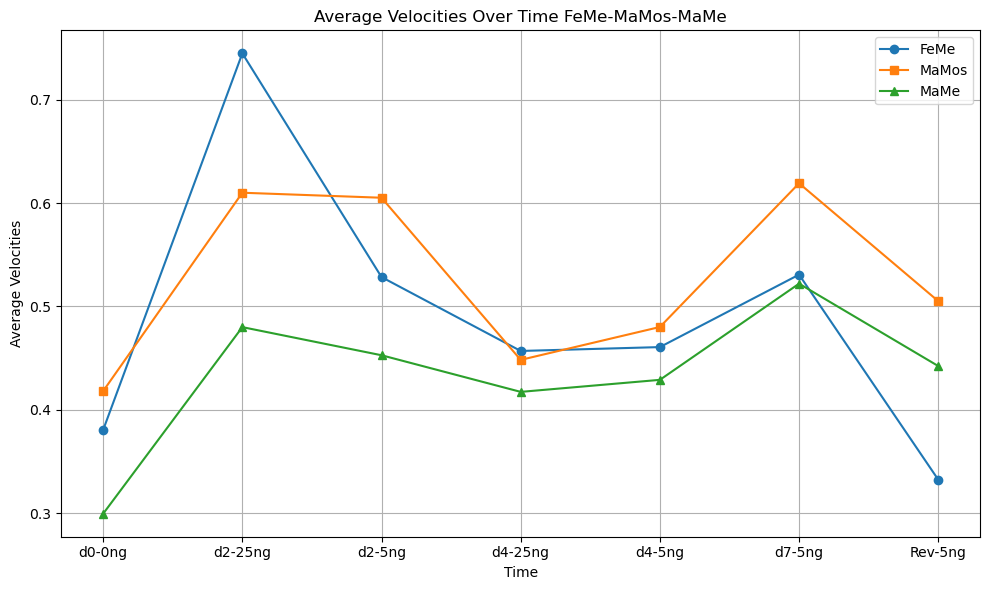

In [29]:
import matplotlib.pyplot as plt

# Data
FeMe =[0.3804431038655152, 0.7448662072437466, 0.5283538430378948, 0.45685637606029394, 0.4606032813647054, 0.53071845009572, 0.3323246911673437]
MaMos =[0.4180250325938298, 0.6099856766349435, 0.6051364456600985, 0.4482261839302416, 0.4800511273053549, 0.6191344990308023, 0.505077477710388]
MaMe= [0.2993674564081986, 0.4799312948012777, 0.4527102414342644, 0.4172634082820537, 0.4289020075906892, 0.5219834673316732, 0.4422603819568516]

Time = ['d0-0ng', 'd2-25ng', 'd2-5ng','d4-25ng', 'd4-5ng', 'd7-5ng', 'Rev-5ng']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Time, FeMe, label='FeMe', marker='o')
plt.plot(Time, MaMos, label='MaMos', marker='s')
plt.plot(Time, MaMe, label='MaMe', marker='^')

# Labels and Title
plt.xlabel('Time')
plt.ylabel('Average Velocities')
plt.title('Average Velocities Over Time FeMe-MaMos-MaMe')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig("Average Velocities Over Time FeMe-MaMos-MaMe.jpg")
plt.show()



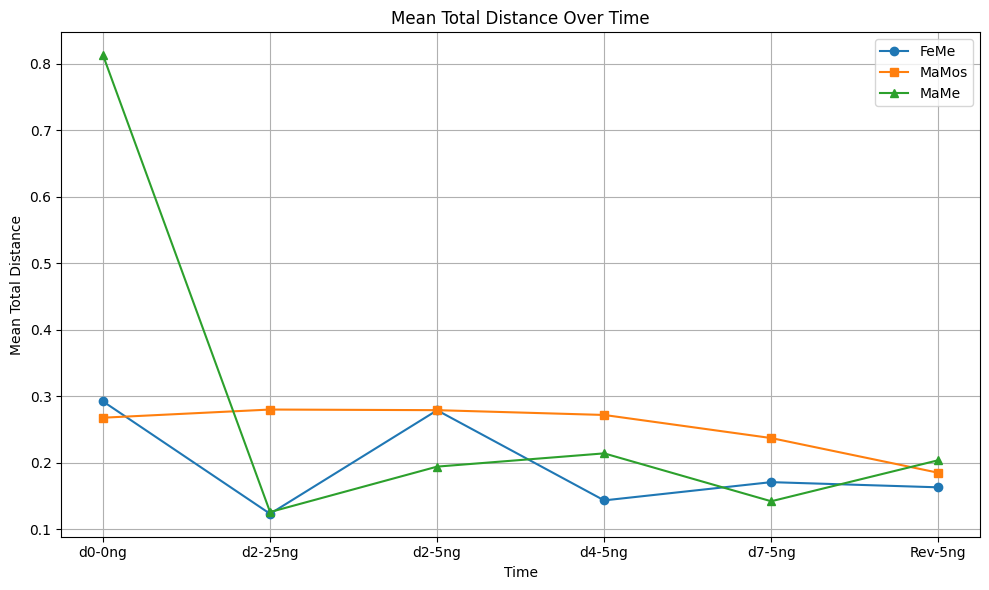

In [2]:
import matplotlib.pyplot as plt

# Data
FeMe = [0.292429742624545, 0.12341966164416969, 0.2791198889469528, 0.14357529661368112, 0.1710282562995867, 0.16323265133330514]
MaMos = [0.2679569988739745, 0.28023756937447136, 0.27929279971736487, 0.2720856301946432, 0.23733541007939693, 0.18515793177148646]
MaMe = [0.81312846778974, 0.12606730017478682, 0.19437678959892837, 0.21431240922183722, 0.1422586106810511, 0.2039538370677772]
Time = ['d0-0ng', 'd2-25ng', 'd2-5ng','d4-25ng', 'd4-5ng', 'd7-5ng', 'Rev-5ng']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Time, FeMe, label='FeMe', marker='o')
plt.plot(Time, MaMos, label='MaMos', marker='s')
plt.plot(Time, MaMe, label='MaMe', marker='^')

# Labels and Title
plt.xlabel('Time')
plt.ylabel('Mean Total Distance')
plt.title('Mean Total Distance Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
import os
import pandas as pd

# Input folder containing CSV files
input_folder = r"C:\Users\MAY02\Desktop\FishTracking-\Data\FeMe-MaMos-MaMe"

# Initialize dictionaries to store average velocities
average_velocities = {0: [], 1: [], 2: []}  # 0 -> FeMe, 1 -> MaMos, 2 -> MaMe
time_points = []

# Process each file in the folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        # Full path to the file
        file_path = os.path.join(input_folder, file_name)
        
        # Extract the time label from the file name
        time_label = file_name.replace('_tracking_data.csv', '')
        time_points.append(time_label)
        
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Group by 'part' and calculate mean 'average_velocity_by_part'
        grouped = df.groupby('part')['average_velocity_by_part'].mean()
        
        # Append the results to the corresponding lists
        for part in average_velocities.keys():
            average_velocities[part].append(grouped.get(part, 0))  # Default to 0 if part is missing

# Convert parts to labels for readability
labels = {0: 'FeMe', 1: 'MaMos', 2: 'MaMe'}
average_velocities_named = {labels[key]: values for key, values in average_velocities.items()}

# Display the collected average velocities for each part
print("Collected Average Velocities by Part:")
for part, velocities in average_velocities_named.items():
    print(f"{part}: {velocities}")

# Save results to a CSV file
output_file = os.path.join(input_folder, "average_velocities_summary.csv")
result_df = pd.DataFrame(average_velocities_named, index=time_points)
result_df.index.name = "Time"
result_df.to_csv(output_file)

print(f"\nSummary saved to: {output_file}")


Collected Average Velocities by Part:
FeMe: [0.404971149029692, 0.5137906179104504, 0.43526493737217903, 0.456228171504162, 0.3242325792640491]
MaMos: [0.5569075017648862, 0.5074266057020352, 0.5885575030757783, 0.4763049712130347, 0.4525407844213348]
MaMe: [0.5548855308804376, 0.4880200571544823, 0.5511778755062122, 0.3938628634790321, 0.42250598005677337]

Summary saved to: C:\Users\MAY02\Desktop\FishTracking-\Data\MaMe-FeMos-FeMe\average_velocities_summary.csv


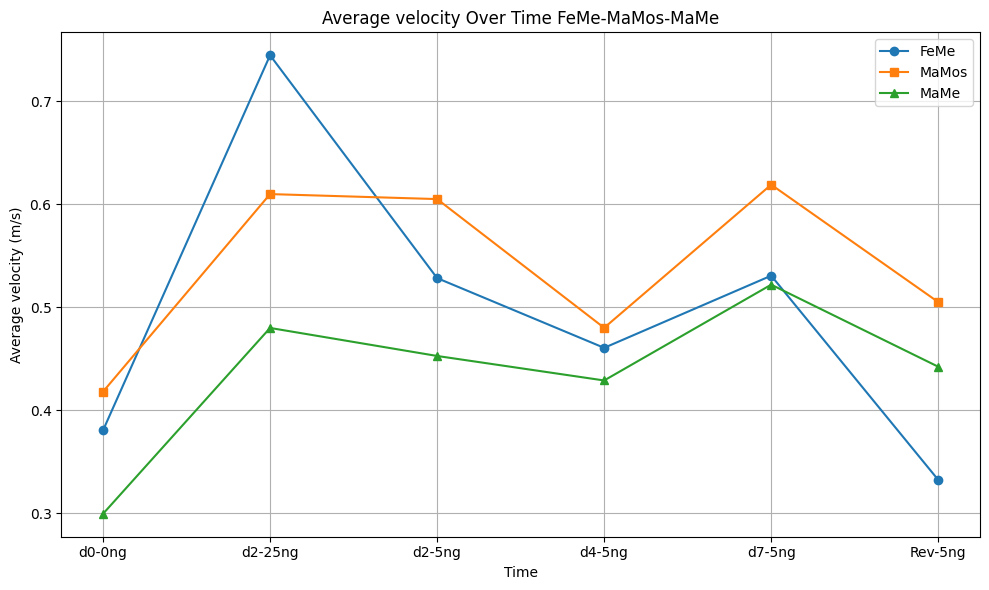

In [7]:
import matplotlib.pyplot as plt

# Data
FeMe =[0.404971149029692, 0.5137906179104504, 0.43526493737217903, 0.456228171504162, 0.3242325792640491]
MaMos: [0.5569075017648862, 0.5074266057020352, 0.5885575030757783, 0.4763049712130347, 0.4525407844213348]
MaMe: [0.5548855308804376, 0.4880200571544823, 0.5511778755062122, 0.3938628634790321, 0.42250598005677337]
Time = ['d0-0ng', 'd2-25ng', 'd2-5ng', 'd4-5ng', 'd7-5ng',]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Time, FeMe, label='FeMe', marker='o')
plt.plot(Time, MaMos, label='MaMos', marker='s')
plt.plot(Time, MaMe, label='MaMe', marker='^')

# Labels and Title
plt.xlabel('Time')
plt.ylabel('Average velocity (m/s)')
plt.title('Average velocity Over Time FeMe-MaMos-MaMe')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig("FeMe-MaMos-MaMe-Average velocity.png")

plt.show()


In [7]:
import pandas as pd
import numpy as np

# Load the CSV file
input_file = r"C:\Users\MAY02\Desktop\FishTracking-\MaMe-FeMos-FeMe-d4-5ng_tracking_data.csv"
df = pd.read_csv(input_file)

# Ensure data is sorted by 'Object ID' and 'Frame'
df = df.sort_values(by=['Object ID', 'Frame'])

# 1. Calculate Distance (Euclidean distance between consecutive frames for the same Object ID)
df['X_diff'] = df.groupby('Object ID')['X Center'].diff().fillna(0)
df['Y_diff'] = df.groupby('Object ID')['Y Center'].diff().fillna(0)
df['Distance'] = np.sqrt(df['X_diff']**2 + df['Y_diff']**2)

# 2. Calculate total_distance (cumulative sum of distances per Object ID)
df['total_distance'] = df.groupby('Object ID')['Distance'].cumsum()

# 3. Calculate average_velocity_by_object_id
df['average_velocity_by_object_id'] = df.groupby('Object ID')['Velocity (m/s)'].transform('mean')

# 4. Calculate average_velocity_by_part
# Define part based on 'X Center' ranges
x1, x2 = 740, 1165
df['part'] = pd.cut(df['X Center'], bins=[-np.inf, x1, x2, np.inf], labels=[2, 1, 0])
df['average_velocity_by_part'] = df.groupby('part')['Velocity (m/s)'].transform('mean')

# Drop intermediate columns (optional)
df = df.drop(columns=['X_diff', 'Y_diff'])

# Save the updated DataFrame to the same CSV file
output_file = input_file  # Overwrite the input file
df.to_csv(output_file, index=False)

print("Updated DataFrame saved to:", output_file)


C:\Users\MAY02\AppData\Local\Temp\ipykernel_45456\2054041806.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['average_velocity_by_part'] = df.groupby('part')['Velocity (m/s)'].transform('mean')


Updated DataFrame saved to: C:\Users\MAY02\Desktop\FishTracking-\MaMe-FeMos-FeMe-d4-5ng_tracking_data.csv


In [ ]:
plt.axvline(x=740, color='red', linestyle='--', label='X = 29')  # Vertical line at X = 29

plt.axvline(x=1165, color='red', linestyle='--', label='X = 29')  # Vertical line at X = 29


In [ ]:
plt.axvline(x=746, color='red', linestyle='--', label='X = 29')  # Vertical line at X = 29

plt.axvline(x=1154, color='red', linestyle='--', label='X = 29')  # Vertical line at X = 29

Initial DataFrame:
          Frame  Object ID     X Center    Y Center  Velocity (m/s)  part  \
0           3.0          1   832.854063  638.061758        0.000000     1   
1           3.0          2  1008.907024  314.230042        0.000000     1   
2           3.0          3  1250.510419  821.839865        0.000000     2   
3           3.0          4  1129.075419  715.791403        0.000000     1   
4           3.0          5  1195.996547  322.976293        0.000000     2   
...         ...        ...          ...         ...             ...   ...   
180996  18450.0       5267   640.448885  866.070723        0.099840     0   
180997  18450.0       5274  1279.454452  859.000519        0.206612     2   
180998  18450.0       5277   712.536237  684.239478        0.448459     0   
180999  18450.0       5281   800.211961  420.140956        0.377971     1   
181000  18450.0       5284  1480.787633  280.862238        0.299738     2   

        average_velocity_by_object_id  average_velocity_

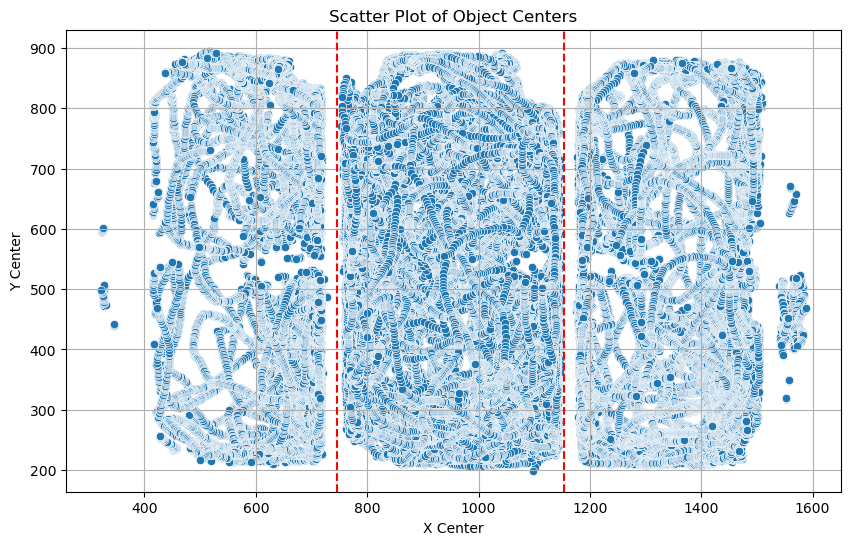

In [66]:
-